In [1]:
import pandas as pd
import numpy as np
from lxml import etree
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer

# Extractive Text Summarization
This project aims to summarize administrative orders using the extractive text summarization method. This method involves selecting sentences to compose the summary for a document. Two methods were tested:
1. getting top N sentence using heuristics
2. getting a sentence from each of N topics (clusters) found in document

## Get Document
Given a file name, get the subject and body of document

In [2]:
doc_parts = ['subject', 'body']

In [3]:
file_name = "data/2017_AO0002.pdf.tiff.txt"

content = open(file_name, 'rb').read()
AO = "<root>" + str(content).replace("<missing text>", "").replace("<missingtext>", "").replace("</missingtext>", "").replace("&", "&amp;") + "</root>"
AO = etree.parse(StringIO(AO), parser=etree.XMLParser(recover=True)).getroot()
etree.strip_tags(AO, 'b')

file = {}
for part in doc_parts:
    if len(AO.xpath('./' + part)) > 0:
        part_content = AO.xpath('./' + part)[0].text
        file[part] = part_content.encode().decode('unicode_escape').encode('ascii','ignore').decode().strip('\n').replace('\n', ' ').replace('\r', '').replace('\t', '')

# Getting top N sentences using heuristics
Selecting N sentences based on a scoring function based on tfidf, cosine similarity to subject and sentence position
http://research.nii.ac.jp/ntcir/workshop/OnlineProceedings3/NTCIR3-TSC-SekiY.pdf

## Create Dataframe of Sentences
Using spaCy, get sentences

In [4]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [5]:
doc = nlp(file['body'])
sentences = [sent.string.strip() for sent in doc.sents]

The number of sentences

In [6]:
len(sentences)

173

## TF-IDF Vectorizer
Treat each sentence as a document. TF refers to frequency of a term in sentence. DF refers to frequency of word across whole document.

### Tokenizer

In [7]:
from string import punctuation

def spacy_tokenize(document):
    doc = nlp(document)
    lemmatized = [token.lemma_.strip(punctuation) for token in doc if not token.is_punct and not token.is_space and not token.is_stop]
    return lemmatized

### Vectorizer

In [8]:
vect = TfidfVectorizer(tokenizer=spacy_tokenize, stop_words='english', ngram_range=(1,3), strip_accents='ascii')

In [9]:
vect = vect.fit(sentences)

In [10]:
dtm = vect.transform(sentences)

In [11]:
subj_dtm = vect.transform([file['subject']])

## Top N Sentences

Start with 4 sentences

In [12]:
num_sentences = 4

Features used TF-IDF score, Similarity to Subject, sentence position,  

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
def similarity(title, sentence):
    t = spacy_tokenize(title)
    s = spacy_tokenize(sentence)
    similar = [w for w in s if w in t]
    
    score = (len(similar) * 0.1 ) / len(t)
    return score

In [15]:
doc_length = len(sentences)

tf_idf =  [ sum(sent) for sent in dtm.toarray()] 
cos_sim = [similarity(file['subject'], sent) for sent in sentences]
sent_pos = [i/doc_length for i in range(doc_length)]

### Ranking score

In [16]:
rank = pd.DataFrame()
rank['score'] = [(tfidf + cos) * pos for tfidf, cos, pos in zip(tf_idf, cos_sim, sent_pos)]
rank.head()

,score
0,0.000000
1,0.038429
2,0.028118
3,0.145287
4,0.160957


Indexes of sentences with highest score

In [17]:
sum_sentences = rank.sort_values('score', ascending=False)[: num_sentences].index.tolist()
list.sort(sum_sentences)

In [18]:
sum_sentences

[146, 150, 159, 160]

In [19]:
print(file['subject'])

SUBJECT: Guidelines on the Certification of Free Standing Family Planning Clinics


In [20]:
summary = ""
for i in sum_sentences:
    summary += sentences[i] + " "

print(summary)

Every Free Standing FP Clinics shall ensure that all key staff, pertinent records/ documents, supplies/ equipment in the facilities are made available to the DOH RO FP Program authorized representatives during monitoring visits. Each DOH R0 shall submit a summary of violations on- a semi-annual basis to the WMCHDD and copy furnished the PhilHealths Regional Office stating among others, the name of the health facility, location, its violation and the course of action taken. The management of a Free Standing FP Clinics aggrieved by the decision of the DOH RO may, within ten (10) days after receipt of notice of decision, file a notice of appeal to the Office of the Secretary of Health. Thereupon, the DOH RO shall promptly certify, file a copy of the decision, including all pertinent documents and transcript of hearings on which the decision is based, and forward to the Office of the Secretary for review. 


In [21]:
cosine_similarity(vect.transform([file['body']])[0:1], vect.transform([summary])[0:1])

array([[ 0.38472645]])

# Using Clustering

## Latent Semantic Analysis
Dimension reduction for text data. Scikit-learn recommendeded to reduce features to 100 for LSA

In [22]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

In [23]:
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [24]:
lsa_dtm = lsa.fit_transform(dtm)

## KMeans Clustering

In [25]:
from sklearn.cluster import KMeans

Cluster similar sentences together

In [26]:
cluster = KMeans(n_clusters=num_sentences)

In [27]:
cluster.fit(lsa_dtm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
labels = cluster.predict(lsa_dtm)
labels

array([3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 0, 3, 2, 3, 3, 1, 0, 3, 1, 0, 3,
       3, 2, 3, 2, 2, 3, 2, 0, 3, 1, 0, 2, 0, 3, 3, 0, 3, 1, 3, 0, 2, 2, 3,
       3, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 3, 2, 3, 0, 0, 2, 2, 3, 2, 2, 2,
       3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 0, 1, 3, 3, 3, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 3, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 3, 0, 0, 0, 2, 2, 3, 2, 2, 1,
       3, 0, 0, 2, 3, 0, 0, 1, 3, 0, 2, 0, 0, 2, 0, 3, 1, 3, 2, 0, 2, 3, 0,
       0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2])

Add cluster labels to the ranking dataframe

In [29]:
rank['cluster'] = labels
rank.head()

,score,cluster
0,0.000000,3
1,0.038429,3
2,0.028118,2
3,0.145287,3
4,0.160957,3


In [44]:
import matplotlib.pyplot as plt

In [47]:
svd_vis = TruncatedSVD(n_iter=100)
normalizer_vis = Normalizer(copy=False)
lsa_vis = make_pipeline(svd_vis, normalizer_vis)
vis = lsa_vis.fit_transform(dtm)

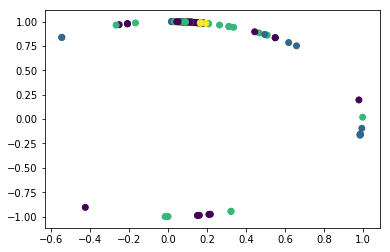

In [52]:
plt.scatter(vis[:,0],vis[:,1], c=rank['cluster'])

In [30]:
idx_k = rank[rank.cluster == 0].sort_values('score', ascending=False).index
for i in idx_k:
    print(str(i+1) + ") " + sentences[i])

151) Each DOH R0 shall submit a summary of violations on- a semi-annual basis to the WMCHDD and copy furnished the PhilHealths Regional Office stating among others, the name of the health facility, location, its violation and the course of action taken.
161) Thereupon, the DOH RO shall promptly certify, file a copy of the decision, including all pertinent documents and transcript of hearings on which the decision is based, and forward to the Office of the Secretary for review.
144) The DOH R0 FP program shall from time to time conduct monitoring inspections during office hours using the Checklist based on this Order and other FP regulations such as that on informed choice and voluntarism.
169) invalid by any court of law or competent authority, those provisions not affected by such declaration shall remain valid and in force.
90) All documents defined in this Order such as application forms, proof of ownership, government registrations, reports, notifications of permits and licensessha

## Choosing Salient Sentences
Get sentence with the highest score per cluster

In [40]:
clustered_summary = ""
sent_idxs = [rank[rank.cluster == i].sort_values('score', ascending=False).head(1).index[0] for i in range(num_sentences)]
list.sort(sent_idxs)

for i in range(num_sentences):
    clustered_summary += sentences[sent_idxs[i]] + " "
#     clustered_summary += str(i+1) + ") " + sentences[sent_idxs[i]]
#     clustered_summary += "\n"

print(sent_idxs)
print(clustered_summary)

[87, 135, 146, 150]
Free Standing FP Clinics should strive to keep the amount of personnel and equipment and size of facilities commensurate to the number of FF clients and consultations.-   C. Certificate of Compliance for a Free Standing FP Clinics (Annex B)   VII. Registration and Issuance   a) Upon receipt of the summary report from the DOH R0 FP program, the WMCHDD shall register the various facilities (whether compliant or non-compliant) in a central registry of all Free Standing FP Clinics facilities. Every Free Standing FP Clinics shall ensure that all key staff, pertinent records/ documents, supplies/ equipment in the facilities are made available to the DOH RO FP Program authorized representatives during monitoring visits. Each DOH R0 shall submit a summary of violations on- a semi-annual basis to the WMCHDD and copy furnished the PhilHealths Regional Office stating among others, the name of the health facility, location, its violation and the course of action taken. 


In [32]:
cosine_similarity(vect.transform([file['body']])[0:1], vect.transform([clustered_summary])[0:1])

array([[ 0.45837377]])

## Hidden Markov Models

In [33]:
from hmmlearn.hmm import GaussianHMM

In [34]:
hmm_model = GaussianHMM(n_components=num_sentences, covariance_type='spherical',n_iter=100, random_state=0)

In [35]:
hmm_model.fit(lsa_dtm)

C:\Users\Tomy\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


GaussianHMM(algorithm='viterbi', covariance_type='spherical',
      covars_prior=0.01, covars_weight=1, init_params='stmc',
      means_prior=0, means_weight=0, min_covar=0.001, n_components=4,
      n_iter=100, params='stmc', random_state=0, startprob_prior=1.0,
      tol=0.01, transmat_prior=1.0, verbose=False)

In [36]:
hmm_cluster = hmm_model.predict(lsa_dtm)
hmm_cluster

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 3, 2, 3, 2, 2, 0, 3,
       0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2,
       3, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 2, 2, 3, 1, 0, 2, 0, 0, 0, 3, 2, 1,
       3, 2, 2, 2, 2, 2, 2, 1, 3, 1, 0, 2, 2, 2, 2, 3, 1, 3, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [37]:
rank['hmm_cluster'] = hmm_cluster

In [38]:
idx_0 = rank[rank.hmm_cluster == 0].sort_values('score', ascending=False).index
for i in idx_0:
    print(str(i+1) + ") " + sentences[i])

134) If a facility is rated non-compliant on three consecutive occasions, the waiting period shall be increased to not less than 60 days and not more than 90 days.
149) A Notice of Suspension or Revocation shall be issued within three (3) days for non- compliance with these rules and regulations.
133) A waiting period of not less than 30 days and not more than 45 days shall be enforced to provide reasonable time on improvements for compliance.
125) If the facility is rated for further validation, the Certifying Team shall return within 5 days with a third person to reexamine problem areas.
123) At the end of the one-day visit, the team shall rate the facility as l) compliant; 2) noncompliant; or 3) for further validation.
122) The Certifying Team shall validate the information in the checklist, conduct staff interviews and examination of original documents.
126) The three-person Certifying Team shall then decide to rate the facility as either compliant or non-compliant.
117) Upon the D

## Choosing Salient Sentences
Get sentence with the highest score per cluster

In [41]:
hmm_clustered_summary = ""
hmm_sent_idxs = [rank[rank.hmm_cluster == i].sort_values('score', ascending=False).head(1).index[0] for i in range(num_sentences)]
# list.sort(hmm_sent_idxs)

for i in range(num_sentences):
    hmm_clustered_summary += sentences[hmm_sent_idxs[i]] + " "
#     hmm_clustered_summary += str(i+1) + ") " + sentences[hmm_sent_idxs[i]]
#     hmm_clustered_summary += "\n"

print(hmm_sent_idxs)
print(hmm_clustered_summary)

[133, 129, 150, 146]
If a facility is rated non-compliant on three consecutive occasions, the waiting period shall be increased to not less than 60 days and not more than 90 days. (See Annex C) Each DOH R0 shall submit a summary of violations on- a semi-annual basis to the WMCHDD and copy furnished the PhilHealths Regional Office stating among others, the name of the health facility, location, its violation and the course of action taken. Every Free Standing FP Clinics shall ensure that all key staff, pertinent records/ documents, supplies/ equipment in the facilities are made available to the DOH RO FP Program authorized representatives during monitoring visits. 
